<a href="https://colab.research.google.com/github/vishalsingh1080/endToend_Emotion_detection/blob/main/TF_emo_detect_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Conv2D,Dropout,BatchNormalization,MaxPool2D
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
device_name = tf.test.gpu_device_name()
device_name 

'/device:GPU:0'

In [4]:
# !unzip -q '/content/gdrive/My Drive/emotion_detection/FER2013.zip' -d FER2013
# !unzip -q '/content/gdrive/My Drive/emotion_detection/private_test.zip' -d private_test

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [5]:
img = cv2.imread('/content/FER2013/train/angry/Training_10118481.jpg')
img.shape

(48, 48, 3)

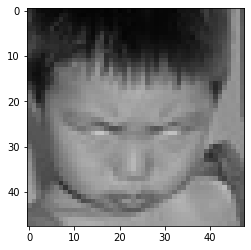

In [6]:
plt.imshow(img)

In [7]:
img = cv2.imread('/content/private_test/disgust/disgust-000034.png')
img.shape

(48, 48, 3)

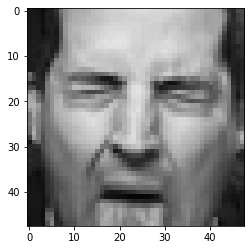

In [8]:
plt.imshow(img)

In [9]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator( rescale=1./255,
                            rotation_range=20,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            horizontal_flip=True)
# initialize the validation/testing data augmentation object 
valAug = ImageDataGenerator(rescale=1./255)

In [10]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
	'/content/FER2013/train',
  class_mode="categorical",
	target_size=(48,48),
	color_mode="grayscale",
	shuffle=True,
	batch_size=64)
# initialize the validation generator
valGen = valAug.flow_from_directory(
	'/content/FER2013/test',
  class_mode="categorical",
	target_size=(48,48),
	color_mode="grayscale",
	shuffle=False,
	batch_size=64)
# initialize the testing generator
testGen = valAug.flow_from_directory(
	'/content/private_test',
  class_mode="categorical",
	target_size=(48,48),
	color_mode="grayscale",
	shuffle=False,
	batch_size=64)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [11]:
no_train_files =  sum(len(files) for _, _, files in os.walk(r'/content/FER2013/train'))
no_val_files = sum(len(files) for _, _, files in os.walk(r'/content/FER2013/test'))
no_test_files = sum(len(files) for _, _, files in os.walk(r'/content/private_test'))

print(no_train_files,no_val_files,no_test_files)

28709 7178 3589


In [12]:
test = next(trainGen)
test[0].shape

(64, 48, 48, 1)

In [13]:
trainGen.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [14]:
# path_to_downloaded_file = tf.keras.utils.get_file('rcmalli_vggface_tf_vgg16.h5','https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_vgg16.h5')

# baseModel = VGG16(input_shape=(128, 128,3),include_top = False,weights='/root/.keras/datasets/rcmalli_vggface_tf_vgg16.h5',)
# # baseModel.summary()
# baseModel.layers[-1].output 

# base_output = baseModel.layers[-1].output 
# # new head for fine-tuning
# x = Flatten(name='flatten')(base_output)
# x = Dropout(0.5)(x)
# x = Dense(4096, activation='relu', name='fc6')(x)
# x = Dropout(0.5)(x)
# x = Dense(1024, activation='relu', name='fc7')(x)
# out = Dense(7, activation='softmax', name='classifier')(x)

# model = Model(baseModel.input, out)


In [15]:
def conv2d_custom_pad(input,pad,filters,kernel_size):
    
    x = tf.pad(input, ((0, 0), (int(pad),int(pad)), (int(pad),int(pad)),(0, 0)), "CONSTANT")
    x = Conv2D(filters=filters,kernel_size=kernel_size)(x)
    return x

In [16]:
def VGG16(drop=0.2):
       
      input = tf.keras.Input(shape=(48,48,1))
    
      conv1a = conv2d_custom_pad(input,pad=1,filters=64,kernel_size=3)
      bn1a = BatchNormalization()(conv1a)
      x = relu(bn1a)
      
      conv1b = conv2d_custom_pad(x,pad=1,filters=64,kernel_size=3)
      bn1b = BatchNormalization()(conv1b)
      x = relu(bn1b)
      x = MaxPool2D(2,strides=2)(x)
      
      conv2a = conv2d_custom_pad(x,pad=1,filters=128,kernel_size=3)
      bn2a = BatchNormalization()(conv2a)
      x = relu(bn2a)
      
      conv2b = conv2d_custom_pad(x,pad=1,filters=128,kernel_size=3)
      bn2b = BatchNormalization()(conv2b)
      x = relu(bn2b)
      x = MaxPool2D(2,strides=2)(x)
      
      conv3a = conv2d_custom_pad(x,pad=1,filters=256,kernel_size=3)
      bn3a = BatchNormalization()(conv3a)
      x = relu(bn3a)
      
      conv3b = conv2d_custom_pad(x,pad=1,filters=256,kernel_size=3)
      bn3b = BatchNormalization()(conv3b)
      x = relu(bn3b)
      x = MaxPool2D(2,strides=2)(x)
      
      conv4a = conv2d_custom_pad(x,pad=1,filters=512,kernel_size=3)
      bn4a = BatchNormalization()(conv4a)
      x = relu(bn4a)
      
      conv4b = conv2d_custom_pad(x,pad=1,filters=512,kernel_size=3)
      bn4b = BatchNormalization()(conv4b)
      x = relu(bn4b)
      x = MaxPool2D(2,strides=2)(x)
      
      x = layers.Flatten()(x)
      
      x = Dense(4096)(x)
      x = Dropout(drop)(x)
      x = relu(x)
      
      x = Dense(4096)(x)
      x = Dropout(drop)(x)
      x = relu(x)
      
      output = Dense(7)(x)
      #output = tf.nn.softmax(x)

      model = tf.keras.Model(input,output)
      return model   

In [17]:
model = VGG16()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
tf.compat.v1.pad (TFOpLambda (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 48, 48, 64)        0         
_________________________________________________________________
tf.compat.v1.pad_1 (TFOpLamb (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928 

In [18]:
checkpoint_path = '/content/gdrive/My Drive/emotion_detection/checkpoints/cp.ckpt'

model_save = ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,save_best_only=True,monitor='val_accuracy')

In [19]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

sgd = SGD(lr=0.01, momentum=0.9, decay=0.0001, nesterov=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.75, patience=5, min_lr=0.00001, verbose=1)

model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer=sgd,metrics=["accuracy"])

with tf.device('/device:GPU:0'):
      H = model.fit(
        x=trainGen,
        steps_per_epoch=no_train_files// 64,
        validation_data=valGen,
        validation_steps=no_val_files// 64,
        epochs=300,
        callbacks = [model_save,early_stop,rlrop],
        use_multiprocessing=True)


Epoch 1/300
448/448 [==============================] - 61s 127ms/step - loss: 1.8816 - accuracy: 0.2459 - val_loss: 1.8179 - val_accuracy: 0.2497
Epoch 2/300
448/448 [==============================] - 57s 127ms/step - loss: 1.7652 - accuracy: 0.2685 - val_loss: 1.9693 - val_accuracy: 0.2733
Epoch 3/300
448/448 [==============================] - 58s 128ms/step - loss: 1.6150 - accuracy: 0.3565 - val_loss: 1.4913 - val_accuracy: 0.4280
Epoch 4/300
448/448 [==============================] - 57s 128ms/step - loss: 1.4384 - accuracy: 0.4413 - val_loss: 1.3650 - val_accuracy: 0.4679
Epoch 5/300
448/448 [==============================] - 57s 127ms/step - loss: 1.3342 - accuracy: 0.4850 - val_loss: 1.4000 - val_accuracy: 0.4806
Epoch 6/300
448/448 [==============================] - 57s 128ms/step - loss: 1.2606 - accuracy: 0.5192 - val_loss: 1.2154 - val_accuracy: 0.5324
Epoch 7/300
448/448 [==============================] - 57s 127ms/step - loss: 1.2018 - accuracy: 0.5422 - val_loss: 1.2154 -

In [20]:
model.save('/content/gdrive/My Drive/emotion_detection/checkpoints/' + 'VGG16-MyCp' + '.h5')

In [21]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
testGen.reset()
predIdxs = model.predict(x=testGen,
	steps=(no_test_files // 64) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))

              precision    recall  f1-score   support

       angry       0.69      0.57      0.62       491
     disgust       0.55      0.65      0.60        55
        fear       0.62      0.38      0.47       528
       happy       0.87      0.91      0.89       879
     neutral       0.64      0.68      0.66       626
         sad       0.47      0.68      0.56       594
    surprise       0.83      0.72      0.77       416

    accuracy                           0.68      3589
   macro avg       0.67      0.65      0.65      3589
weighted avg       0.69      0.68      0.68      3589

